# 🧠 Critical Question Generation using Fine-Tuned Flan-T5-small
This notebook presents an end-to-end pipeline for generating critical questions using a fine-tuned Flan-T5-small model. Critical Question Generation (CQG) involves generating insightful, probing questions from a given context and answer. The project showcases data processing, model fine-tuning, and evaluation using state-of-the-art open-source tools.

## 1. Installing Project Dependencies
This cell installs all the core dependencies required for the critical question generation project that uses the FLAN-T5-small model. Each library serves a distinct role in enabling model usage, data handling, evaluation, and natural language processing.

In [1]:
!pip install transformers==4.51.3 datasets evaluate sentencepiece nltk bert_score

## 2. Suppressing Warning Messages

This cell is used to suppress warning messages that may be generated during the execution of the notebook. The `warnings` module is imported, and the `filterwarnings('ignore')` function is called to prevent warnings from being displayed in the output. Suppressing warnings can help produce cleaner notebook outputs by hiding non-critical warnings that might otherwise clutter the results. 

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 3. Data Preparation and Paraphrasing for Critical Question Generation

This code cell performs several key tasks in preparing training data for generating critical questions using the FLAN-T5 model, with an emphasis on paraphrasing and data augmentation. The process is organized as follows:

### 3a. Importing Required Libraries

The code imports necessary libraries for file handling, data processing, text similarity evaluation, deep learning, and model loading:
- `os`, `json`, `time`, `random`: Standard Python utilities for system operations and data handling.
- `pandas`: For tabular data processing and exporting to CSV.
- `SequenceMatcher` from `difflib`: Used to evaluate similarity between original and paraphrased questions.
- `torch`: For device management (CPU/GPU) and tensor operations.
- `transformers`: To load the pre-trained T5 model and tokenizer.

### 3b. Configuration

Several configuration parameters are defined:
- `DATA_FILE`: Path to the input JSON file containing validation data.
- `MODEL_NAME`: Specifies the pre-trained paraphrasing model (T5-based) to be used.
- `PARAPHRASES_PER_CQ`: Number of paraphrases to generate for each critical question.
- `MAX_ENTRIES`: Allows limiting the number of entries for processing (set to `None` to process all entries).

### 3c. Model and Tokenizer Loading

The code automatically detects whether a GPU is available and loads the specified model and tokenizer accordingly, ensuring efficient computation.

### 3d. Paraphrase Quality Function

The `is_good_paraphrase` function checks whether a generated paraphrase is sufficiently different from the original question and that its length exceeds a threshold. This helps filter out trivial or uninformative paraphrases.

### 3e. Batch Paraphrase Generation

The `batch_paraphrase` function uses the loaded model to generate paraphrases for a list of questions. It:
- Prepares prompts in the appropriate format for the paraphrasing model.
- Tokenizes and encodes the input batch.
- Generates paraphrases using beam search for diversity.
- Decodes outputs and filters them using the `is_good_paraphrase` function.
- Returns a grouped list of filtered paraphrases for each input question.

### 3f. Data Loading and Preparation

The `load_and_prepare` function reads the input data, processes each entry, and structures the data for model training:
- Loads the dataset from the specified JSON file.
- Extracts arguments, argumentation schemes, and critical questions labeled as "useful".
- Groups critical questions into sets of three, as required for the generation task.
- Constructs input prompts and target outputs for each group, following a consistent format suitable for training sequence-to-sequence models.
- For each group of critical questions, generates paraphrases (if enabled) and creates additional data entries with paraphrased questions, enhancing the diversity of the training dataset.

### 3g. Data Export

The processed data is saved in both CSV and JSON formats for flexibility in downstream tasks and reproducibility.

### 3h. Output

The script prints the total number of examples generated, including both original and paraphrased entries.
This cell provides a comprehensive pipeline for augmenting and structuring critical question generation data, facilitating robust model training with enhanced linguistic variety.

In [3]:
import os
import json
import time
import random
import pandas as pd
from difflib import SequenceMatcher
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# --------------------- CONFIG ---------------------
DATA_FILE = "/kaggle/input/training-flant5/validation.json"
MODEL_NAME = "Vamsi/T5_Paraphrase_Paws"
PARAPHRASES_PER_CQ = 1
MAX_ENTRIES = None
# --------------------------------------------------

# Load model and tokenizer
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME).to(device)

def is_good_paraphrase(original, paraphrase):
    """Check if the paraphrase is different enough and not too short."""
    ratio = SequenceMatcher(None, original.lower(), paraphrase.lower()).ratio()
    return ratio < 0.85 and len(paraphrase.split()) > 4

def batch_paraphrase(questions, num_return_sequences=1, max_length=128):
    """Generate paraphrases for a list of questions."""
    prompts = [f"paraphrase: {q} </s>" for q in questions]
    encoding = tokenizer(prompts, padding=True, truncation=True, return_tensors="pt").to(device)

    outputs = model.generate(
        input_ids=encoding["input_ids"],
        attention_mask=encoding["attention_mask"],
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        num_beams=max(4, num_return_sequences),
        early_stopping=True
    )

    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    # Group decoded outputs per input question
    grouped = [decoded[i*num_return_sequences:(i+1)*num_return_sequences] for i in range(len(questions))]

    clean_results = []
    for orig, paras in zip(questions, grouped):
        filtered = [p for p in paras if is_good_paraphrase(orig, p)]
        clean_results.append(filtered)
    return clean_results

def load_and_prepare(file_path, paraphrase_each_cq=True, paraphrases_per_cq=1, max_entries=None):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"{file_path} does not exist.")
    with open(file_path, "r") as f:
        raw_data = json.load(f)

    data = []
    entries = list(raw_data.items())[:max_entries] if max_entries else list(raw_data.items())

    for k, entry in entries:
        argument = entry["intervention"].replace("\n", " ").strip()
        schemes = list(set(entry.get("schemes", [])))
        scheme_str = ", ".join(schemes)

        useful_cqs = [
            cq["cq"].strip()
            for cq in entry.get("cqs", [])
            if cq.get("label", "").lower() == "useful"
        ]

        for i in range(0, len(useful_cqs), 3):
            cq_group = useful_cqs[i:i+3]
            if len(cq_group) == 3:
                input_text = (
                    "Given the following argumentation scheme and argument, generate exactly three distinct and critical questions. "
                    "Each question should challenge the argument from a different angle. Present the questions in a numbered list format, "
                    "starting from 1: Scheme: {scheme}. Argument: {argument} 1. 2. 3."
                ).format(scheme=scheme_str, argument=argument)
                target_text = f"1. {cq_group[0]} 2. {cq_group[1]} 3. {cq_group[2]}"
                data.append({
                    "input_text": input_text,
                    "target_text": target_text,
                    "paraphrased_from": None
                })

                if paraphrase_each_cq:
                    paraphrases_batch = batch_paraphrase(cq_group, num_return_sequences=paraphrases_per_cq)

                    for idx, paraphrase_list in enumerate(paraphrases_batch):
                        for para in paraphrase_list:
                            new_group = cq_group.copy()
                            new_group[idx] = para
                            new_target = f"1. {new_group[0]} 2. {new_group[1]} 3. {new_group[2]}"
                            data.append({
                                "input_text": input_text,
                                "target_text": new_target,
                                "paraphrased_from": cq_group[idx]
                            })
    return data

# ---------------- RUN ------------------

data = load_and_prepare(DATA_FILE, paraphrase_each_cq=True, paraphrases_per_cq=PARAPHRASES_PER_CQ, max_entries=MAX_ENTRIES)

# Save to CSV and JSON
pd.DataFrame(data).to_csv("cqg_t5_training.csv", index=False)
with open("cqg_t5_training.json", "w") as f:
    json.dump(data, f, indent=2)

print(f"\nSaved {len(data)} total examples (including original + paraphrased)")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
2025-06-01 14:59:39.510646: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748789979.533732    5754 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748789979.540642    5754 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has


Saved 1051 total examples (including original + paraphrased)


## 4. Manual Spot-Check of Paraphrased Critical Questions

This cell defines a function to quickly inspect sample paraphrased critical questions in the dataset, ensuring paraphrases are distinct and meaningful.

### 4a. Functionality:  
  The `manual_spot_check` function selects a specified number of paraphrased examples. For each example, it:
  1. Extracts the original critical question and the generated triplet of questions.
  2. Parses out the three questions.
  3. Calculates string similarity between each question and the original.
  4. Identifies and displays the paraphrased question most similar to the original.

### 4b. Error Handling:  
  If parsing fails, the function reports and skips the problematic entry.

### 4c. Usage:  
  Displays a side-by-side comparison for quick manual review.

In [4]:
import difflib

def manual_spot_check(data, n_pairs=5):
    print(f"\n--- Manual Spot-Check of Paraphrased Data (showing first {n_pairs} examples) ---\n")
    paraphrased_examples = [d for d in data if d.get("paraphrased_from") is not None]
    if not paraphrased_examples:
        print("No paraphrased examples found.")
        return

    samples = paraphrased_examples[:n_pairs]
    for i, row in enumerate(samples, 1):
        original_cq = row['paraphrased_from']
        target_text = row['target_text']

        try:
            parts = target_text.split("1.")[1].strip().split("2.")
            q1 = parts[0].strip()
            q2_q3 = parts[1].split("3.")
            q2 = q2_q3[0].strip()
            q3 = q2_q3[1].strip()
            triplet = [q1, q2, q3]
        except Exception as e:
            print(f"Error parsing triplet in pair {i}: {e}")
            continue

        similarities = [difflib.SequenceMatcher(None, q, original_cq).ratio() for q in triplet]
        most_similar_idx = similarities.index(max(similarities))
        paraphrased_cq = triplet[most_similar_idx]

        print(f"Pair {i}:")
        print("Original CQ:    ", original_cq)
        print("Paraphrased CQ: ", paraphrased_cq)
        print("-" * 80)

# Usage
manual_spot_check(data, n_pairs=5)


--- Manual Spot-Check of Paraphrased Data (showing first 5 examples) ---

Pair 1:
Original CQ:     Are there alternative actions to working more closely with the USA's allies to achieve vacuuming up intelligence from Europe and the Middle East? If so, which is the most efficient action?
Paraphrased CQ:  Are there alternative actions to working more closely with the USA allies to vacuum up intelligence from Europe and the Middle East?
--------------------------------------------------------------------------------
Pair 2:
Original CQ:     What evidence does Clinton have that Iran had built "covert facilities" and stocked them with centrifuges? Are these claims supported by credible sources?
Paraphrased CQ:  What evidence does Clinton have that Iran had built "covert facilities" and stocked them with centrifuges?
--------------------------------------------------------------------------------
Pair 3:
Original CQ:     What is the evidence for the claim that NATO has only invoked Article 

## 5. Tokenization and Dataset Preparation for FLAN-T5

This section prepares the dataset for fine-tuning or evaluating the FLAN-T5 model on the Critical Question Generation (CQG) task. It ensures that the input and target sequences are properly tokenized and formatted for supervised training using Hugging Face’s `transformers` and `datasets` libraries.

### 5a. Dataset Loading & Splitting

- The CSV file is loaded using Hugging Face’s `load_dataset` function.
- It is assumed that the CSV contains two columns: `"input_text"` and `"target_text"`.
- The dataset is split into training and test sets, with 20% of the data reserved for testing.
- A random seed is specified (`seed=42`) to ensure reproducibility.

### 5b. Tokenizer Initialization

- The `AutoTokenizer` is used to load the tokenizer for the `google/flan-t5-small` model.
- This tokenizer is responsible for:
  - Converting text inputs into token IDs.
  - Adding special tokens required by the model.
  - Handling truncation and padding.

### 5c. Tokenization Function

- A custom function is defined to tokenize both the input and target text.
- For each example:
  - `"input_text"` is tokenized with a maximum length of 512 tokens.
  - `"target_text"` is tokenized with a maximum length of 128 tokens.
  - Both are padded to fixed lengths (`padding="max_length"`) and truncated if necessary.
  - The target’s token IDs (`input_ids`) are stored in the `"labels"` field, which is expected by the model during training.

### 5d. Batch Tokenization & Formatting

- The dataset is tokenized in batches using the `.map()` method for efficiency.
- The original columns (`"input_text"` and `"target_text"`) are removed to retain only the tokenized data.
- The final dataset is formatted for PyTorch using `.set_format("torch")`, making it ready for training with Hugging Face’s `Trainer` API.

In [5]:
from datasets import load_dataset

dataset = load_dataset("csv", data_files="cqg_t5_training.csv")["train"]
dataset = dataset.train_test_split(test_size=0.2, seed=42)

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")
max_input_length = 512
max_target_length = 128

def tokenize_function(example):
    input_enc = tokenizer(
        example["input_text"],
        max_length=max_input_length,
        padding="max_length",
        truncation=True
    )
    target_enc = tokenizer(
        example["target_text"],
        max_length=max_target_length,
        padding="max_length",
        truncation=True
    )
    input_enc["labels"] = target_enc["input_ids"]
    return input_enc

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["input_text", "target_text"])
tokenized_dataset.set_format("torch")

Generating train split: 0 examples [00:00, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

Map:   0%|          | 0/211 [00:00<?, ? examples/s]

## 6. Custom Dataset Class for Evaluation

This cell defines a simple PyTorch Dataset, `CQGDataset`, for easy access to data samples and integration with PyTorch DataLoader.

- `CQGDataset` wraps a data list, providing `__getitem__` and `__len__` methods.
- An instance, `eval_dataset`, is created from the processed `data` list for evaluation or custom loading.

In [6]:
from torch.utils.data import Dataset

class CQGDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __getitem__(self, idx):
        return self.data[idx]
    def __len__(self):
        return len(self.data)

eval_dataset = CQGDataset(data)

## 7. Model Loading

This cell loads the FLAN-T5-small model and moves it to the appropriate device (GPU if available, otherwise CPU). This prepares the model for inference or further fine-tuning.

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "google/flan-t5-small"
base_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME).to(device)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

## 8. Fine-Tuning FLAN-T5

This section sets up and executes the fine-tuning process for the FLAN-T5 model using Hugging Face’s `Trainer` API. It defines training parameters, handles data collation, and initiates training with automatic evaluation and checkpointing.

### 8a. Imports

- Required classes are imported from the `transformers` library:
  - `TrainingArguments`: For configuring training behavior.
  - `DataCollatorForSeq2Seq`: For dynamic padding of input/output sequences.
  - `Trainer`: For managing the training loop.

### 8b. TrainingArguments

- Training configuration is specified using `TrainingArguments`:
  - `output_dir`: Directory to save training results.
  - `per_device_train_batch_size` and `per_device_eval_batch_size`: Batch sizes for training and evaluation.
  - `num_train_epochs`: Number of complete passes over the training data.
  - `eval_strategy` and `save_strategy`: Set to `"epoch"` to evaluate and save after each epoch.
  - `logging_dir` and `logging_steps`: Set up logging directory and frequency.
  - `save_total_limit`: Keeps the most recent 2 checkpoints to limit storage use.
  - `load_best_model_at_end`: Automatically reloads the best-performing model after training.
  - `report_to`: Set to `"none"` to disable reporting to external services like Weights & Biases.

### 8c. Data Collator

- `DataCollatorForSeq2Seq` is used to:
  - Dynamically pad inputs and labels to the maximum length within each batch.
  - Ensure compatibility with sequence-to-sequence architectures like T5.

### 8d. Trainer Setup and Training

- The `Trainer` is initialized with:
  - The model to be trained.
  - Training arguments.
  - Tokenized training and evaluation datasets.
  - Tokenizer and data collator.
- Training is started with `.train()`.
- After training:
  - The fine-tuned model is saved to the `"finetuned_flant5_model"` directory.
  - The tokenizer is also saved for consistent downstream inference.

In [8]:
from transformers import TrainingArguments, DataCollatorForSeq2Seq, Trainer

print("Fine-tuning Flan-T5...")
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=20,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=50,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none"
)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=base_model)
trainer = Trainer(
    model=base_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator
)
trainer.train()
trainer.save_model("finetuned_flant5_model")
tokenizer.save_pretrained("finetuned_flant5_model")

Fine-tuning Flan-T5...


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,3.567800,2.615092
2,2.442700,1.897156
3,1.931100,1.583439
4,1.711300,1.461299
5,1.576400,1.402595
6,1.482900,1.367690
7,1.421400,1.342189
8,1.383100,1.321624
9,1.345500,1.304103
10,1.330100,1.294449


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


('finetuned_flant5_model/tokenizer_config.json',
 'finetuned_flant5_model/special_tokens_map.json',
 'finetuned_flant5_model/spiece.model',
 'finetuned_flant5_model/added_tokens.json',
 'finetuned_flant5_model/tokenizer.json')

## 9. Visualizing Training and Validation Loss

This section visualizes the training and validation loss curves over epochs using Matplotlib. It helps in understanding the model's learning behavior and diagnosing overfitting or underfitting.

### 9a. Extract Training Logs

- After training completes, the `Trainer` stores logs in `trainer.state.log_history`.
- Each log entry may contain:
  - `loss`: Training loss at a given step or epoch.
  - `eval_loss`: Evaluation (validation) loss at a given epoch.
  - `step` and `epoch`: Step or epoch at which the log was recorded.

### 9b. Parse Logs for Plotting

- Iterate through `log_history` to collect:
  - Training loss and corresponding epochs.
  - Evaluation loss and corresponding epochs.
- Separate lists are maintained for plotting each loss type.

### 9c. Plot Loss Curves

- Matplotlib is used to plot training and validation loss curves.
- The X-axis represents epochs, and the Y-axis represents loss values.
- Both curves are displayed in a single plot for easy comparison.

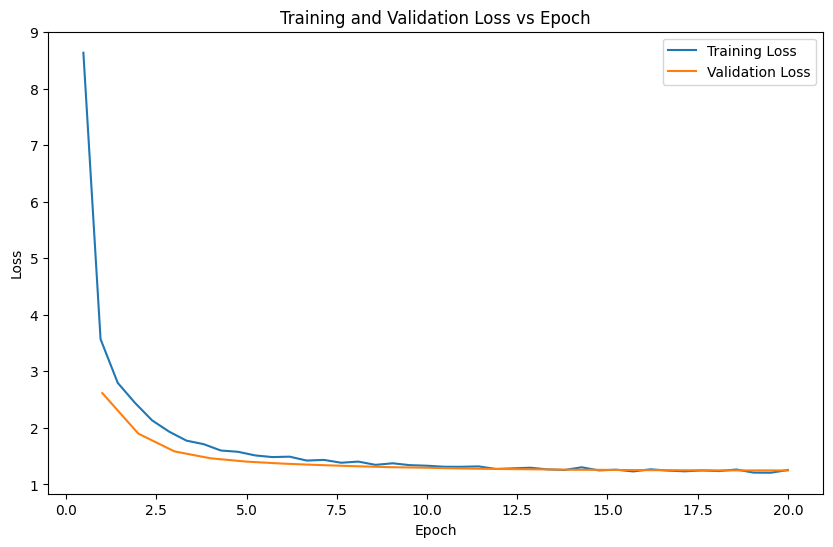

In [9]:
import matplotlib.pyplot as plt

# After training with Hugging Face Trainer
# Assuming you have run trainer.train()
log_history = trainer.state.log_history

# Extract losses and steps/epochs
train_loss = []
eval_loss = []
steps = []
epochs = []
eval_steps = []
eval_epochs = []

for log in log_history:
    if 'loss' in log:
        train_loss.append(log['loss'])
        steps.append(log.get('step', None))
        epochs.append(log.get('epoch', None))
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])
        eval_steps.append(log.get('step', None))
        eval_epochs.append(log.get('epoch', None))

# Plot Loss vs Epochs (if you want per-epoch, use unique epochs)
plt.figure(figsize=(10,6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(eval_epochs, eval_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epoch')
plt.legend()
plt.show()

## 10. Model Evaluation with Batched Inference

This section defines a function to evaluate the fine-tuned FLAN-T5 model using batched input data. It generates predictions with sampling-based decoding strategies and returns the generated outputs alongside reference texts and inputs.

### 10a. Prepare Evaluation Dataset

- Removes the `"paraphrased_from"` key from each example to keep only relevant fields (`"input_text"` and `"target_text"`).

### 10b. Batched Evaluation Function

- Uses a `DataLoader` to iterate over the dataset in batches.
- Tokenizes input texts with padding and truncation.
- Generates outputs with parameters enabling nucleus and top-k sampling, temperature scaling, repetition penalties, and early stopping.
- Collects predictions, references, and input texts.
- Optionally limits the number of evaluated samples via `sample_size`.

In [10]:
eval_dataset = [
    {k: v for k, v in example.items() if k != "paraphrased_from"}
    for example in data
]

def evaluate_model_batched(model, tokenizer, dataset, batch_size=8, max_new_tokens=128, max_input_length=512, sample_size=None):
    model.eval()
    predictions, references, inputs_logged = [], [], []
    dataloader = DataLoader(dataset, batch_size=batch_size)
    count = 0
    for batch in dataloader:
        input_texts = batch["input_text"]
        target_texts = batch["target_text"]
        inputs = tokenizer(
            input_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_input_length
        ).to(model.device)
        with torch.no_grad():
            outputs = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_new_tokens=256,              
                do_sample=True,           
                top_k=30,                 
                top_p=0.95,               
                temperature=0.4,        
                num_beams=3,              
                early_stopping=True,
                no_repeat_ngram_size=6,
                repetition_penalty=1.4,
                num_return_sequences=1,
        )
        predicted_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        predictions.extend(predicted_texts)
        references.extend(target_texts)
        inputs_logged.extend(input_texts)
        count += len(input_texts)
        if sample_size and count >= sample_size:
            break
    return predictions[:sample_size], references[:sample_size], inputs_logged[:sample_size]

## 11. Evaluating the Fine-Tuned FLAN-T5 Model

This section demonstrates how to load the fine-tuned FLAN-T5 model and run batched evaluation on the prepared evaluation dataset. It then prints a sample prediction along with its input prompt and reference output.

### 11a. Load Fine-Tuned Model

- The fine-tuned model is loaded from the saved checkpoint directory `"finetuned_flant5_model"`.
- The model is moved to the specified device (CPU or GPU).

### 11b. Run Batched Evaluation

- Calls the previously defined `evaluate_model_batched` function to generate predictions for a subset of the evaluation data (here, 100 samples).
- Uses a batch size of 8 and sets the maximum tokens to generate per sample to 128.

### 11c. Display Example Output

- Prints the first example's:
  - Input prompt.
  - Generated output from the model.
  - Ground truth reference text.

In [11]:
from torch.utils.data import DataLoader

print("Evaluating fine-tuned Flan-T5...")
finetuned_model = AutoModelForSeq2SeqLM.from_pretrained("finetuned_flant5_model").to(device)
finetuned_predictions, finetuned_references, finetuned_inputs = evaluate_model_batched(
    finetuned_model, tokenizer, eval_dataset, batch_size=8, max_new_tokens=128, sample_size=100
)

for i in range(1):
    print(f"Example {i+1}")
    print("Input Prompt:", finetuned_inputs[i])
    print("\nGenerated:", finetuned_predictions[i])
    print("\nReference:", finetuned_references[i])
    print("-" * 80)

Evaluating fine-tuned Flan-T5...
Example 1
Input Prompt: Given the following argumentation scheme and argument, generate exactly three distinct and critical questions. Each question should challenge the argument from a different angle. Present the questions in a numbered list format, starting from 1: Scheme: PracticalReasoning, Consequences, CauseToEffect, Example. Argument: CLINTON: "which may prove to be an intelligence benefit we've got to do everything we can to vacuum up intelligence from Europe, from the Middle East That means we've got to work more closely with our allies, and that's something that Donald has been very dismissive of We're working with NATO, the longest military alliance in the history of the world, to really turn our attention to terrorism We're working with our friends in the Middle East, many of which, as you know, are Muslim majority nations Donald has consistently insulted Muslims abroad, Muslims at home, when we need to be cooperating with Muslim nations an

## 12. Computing BERTScore for Fine-Tuned Model Outputs

This section defines a function to compute BERTScore, a semantic similarity metric between generated predictions and reference texts. It first cleans the texts by removing leading numbering or punctuation, then calculates and prints Precision, Recall, and F1 scores.

### 12a. Cleaning Function

- `clean_numbering(text)` removes digits, dots, and leading/trailing spaces from each word in the text.
- This normalization helps to avoid skewing the BERTScore by extraneous numbering or formatting.

### 12b. BERTScore Computation

- The `compute_bertscore` function:
  - Cleans predictions and references.
  - Optionally limits evaluation to a sample size (default 100).
  - Uses the `score` function from the `bertscore` library to compute Precision, Recall, and F1.
  - Prints the averaged metric values.
  
### 12c. Usage

- Calls `compute_bertscore` on the fine-tuned model's predictions and references to evaluate semantic quality.

In [12]:
from bert_score import score

def clean_numbering(text):
    return " ".join(word.strip("1234567890. ") for word in text.strip().split())

def compute_bertscore(preds, refs, sample_size=100):
    clean_preds = [clean_numbering(p) for p in preds]
    clean_refs  = [clean_numbering(r) for r in refs]
    sample_preds = clean_preds[:sample_size]
    sample_refs = clean_refs[:sample_size]
    P, R, F1 = score(sample_preds, sample_refs, lang="en", verbose=True)
    print("\n--- BERTScore Results ---")
    print(f"Precision: {P.mean().item():.4f}")
    print(f"Recall:    {R.mean().item():.4f}")
    print(f"F1:        {F1.mean().item():.4f}")

print("\nFine-tuned Model BERTScore:")
compute_bertscore(finetuned_predictions, finetuned_references)


Fine-tuned Model BERTScore:


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/3 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 2.31 seconds, 43.28 sentences/sec

--- BERTScore Results ---
Precision: 0.8877
Recall:    0.8837
F1:        0.8856


## 13. Generating Critical Questions for a Single Input

This function generates exactly three distinct critical questions based on a provided argumentation scheme and argument. The questions challenge the argument from different perspectives and are formatted as a numbered list.

### 13a. Function Description

- **Inputs:**
  - `model`: The fine-tuned FLAN-T5 model.
  - `tokenizer`: The tokenizer associated with the model.
  - `scheme_str`: A string describing the argumentation scheme.
  - `argument`: The argument text to be challenged.

- **Process:**
  - Constructs a prompt combining the scheme and argument, instructing the model to generate three distinct critical questions.
  - Tokenizes and encodes the input with padding, truncation, and a max length of 512 tokens.
  - Generates output using beam search (`num_beams=3`), with sampling parameters set to encourage diversity and avoid repetition.
  - Decodes the generated token IDs back to text.

- **Output:**
  - Returns the generated critical questions as a single string.

In [13]:
def generate_for_input(model, tokenizer, scheme_str, argument):
    model.eval()
    input_text = (
        f"Given the following argumentation scheme and argument, generate exactly three distinct and critical questions. "
        f"Each question should challenge the argument from a different angle. Present the questions in a numbered list format, "
        f"starting from 1: Scheme: {scheme_str}. Argument: {argument} 1. 2. 3."
    )
    input_ids = tokenizer(
        input_text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    ).input_ids.to(model.device)
    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            max_new_tokens=128,
            do_sample=True,           
            top_k=30,                 
            top_p=0.95,               
            temperature=0.4,        
            num_beams=3,              
            early_stopping=True,
            no_repeat_ngram_size=6,
            repetition_penalty=1.4,
            num_return_sequences=1,
        )
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return generated_text

## 14. Generating and Extracting Critical Questions from Evaluation Data

This section loads a JSON evaluation dataset, generates critical questions for each argument using the fine-tuned model, extracts the questions from the raw model output, and saves the structured results to a JSON file.

### 14a. Loading Evaluation Data

- Loads evaluation data from a JSON file containing argument entries keyed by unique IDs.
- Each entry contains the argument text (`"intervention"`) and associated argumentation schemes (`"schemes"`).

### 14b. Extracting Critical Questions

- Defines `extract_cqs_from_output` to parse generated text and extract critical questions formatted as a numbered list.
- Uses regex to find numbered questions or falls back to splitting by numbers if fewer than three are found.
- Returns the first three extracted questions as a list of dictionaries with key `"cq"`.

### 14c. Generating Questions for Each Example

- Iterates over each entry in the evaluation dataset.
- Constructs a scheme string by joining unique schemes.
- Cleans the argument text by removing newline characters.
- Generates critical questions by calling `generate_for_input` with the fine-tuned model.
- Extracts the questions from the generated output.
- Stores the questions in a dictionary keyed by the example ID.

### 14d. Saving Results

- Writes the generated critical questions to a JSON file for further analysis or submission.

In [19]:
import json
import re
from tqdm.notebook import tqdm

# Load evaluation data
with open("/kaggle/input/eval-data/eval_data.json", "r", encoding="utf-8") as f:
    eval_data = json.load(f)

def extract_cqs_from_output(output_text):
    """
    Extracts critical questions from a generated numbered list string.
    Returns a list of dicts: [{"cq": question1}, {"cq": question2}, {"cq": question3}]
    """
    # Try to find questions matching "1. ... 2. ... 3."
    matches = re.findall(r"\d+\.\s*([^\n]+)", output_text)
    # If few found, fallback to splitting by numbers
    if len(matches) < 3:
        matches = [x.strip() for x in re.split(r"\d+\.\s*", output_text) if x.strip()]
    # Only keep first 3
    return [{"cq": cq.strip()} for cq in matches[:3]]

# --------- Generate for Fine-tuned Model ---------
outputs_finetuned = {}
for k, entry in tqdm(eval_data.items(), desc="Generating (finetuned)"):
    schemes = list(set(entry.get("schemes", [])))
    scheme_str = ", ".join(schemes)
    argument = entry["intervention"].replace("\n", " ").strip()
    generated_text_fine = generate_for_input(finetuned_model, tokenizer, scheme_str, argument)
    cqs = extract_cqs_from_output(generated_text_fine)
    outputs_finetuned[k] = {"cqs": cqs}

with open("/kaggle/working/fine_tuned_model_generated_cqs.json", "w", encoding="utf-8") as f:
    json.dump(outputs_finetuned, f, indent=4, ensure_ascii=False)
print("Fine-tuned model output saved to /kaggle/working/fine_tuned_model_generated_cqs.json")

Generating (finetuned):   0%|          | 0/5 [00:00<?, ?it/s]

Fine-tuned model output saved to /kaggle/working/fine_tuned_model_generated_cqs.json


## 15. Evaluation Script for Critical Question Generation

This evaluation script (`evaluate.py`) is used to quantitatively assess generated critical questions against reference questions using semantic similarity or BLEURT metrics.

- It accepts command-line arguments for:
  - `metric`: Choice between `'similarity'` (using Sentence-BERT) and `'bleurt'` metrics.
  - `input_path`: Path to the reference dataset JSON file.
  - `submission_path`: Path to the generated questions JSON file.
  - `threshold`: Similarity score threshold to consider a match valid.

- The script loads the evaluation models and data, then compares each generated question with reference questions.
- It checks for repeated questions, calculates scores per intervention, and aggregates overall performance.
- Results including labeled questions and evaluation scores are saved to a new JSON file.

### 15a. Note:

This evaluation script is imported from the shared-task website for Critical Questions Generation: 
https://hitz-zentroa.github.io/shared-task-critical-questions-generation/

In [15]:
%%writefile evaluate.py
import json
from sentence_transformers import SentenceTransformer
import numpy as np
from collections import Counter
import sys
import argparse
import logging
# from evaluate import load # if you don't want to use bleurt and you don't have it installed, you can comment this, gpu might be needed

logger = logging.getLogger(__name__)

def main():
    # arguments
    parser = argparse.ArgumentParser(prog='Evaluate')
    parser.add_argument('--metric', default='similarity', type=str, choices=['similarity', 'bleurt'])
    parser.add_argument('--input_path', type=str, default='test.json', help='Path of the test set.')
    parser.add_argument('--submission_path', type=str, default='output.json', help='Path where the generated questions have been saved.')
    parser.add_argument('--threshold', type=float, default=0.6, help='Threshold to determine when the sentences are not similar. For bleurt, the threshold should probably be a negative number.') 
    args = parser.parse_args()

    #logger
    logging.basicConfig(filename='eval.log', level=logging.INFO)
    logger.info('THRESHOLD: '+str(args.threshold)+'\nMETRIC: '+args.metric)

    # load the similarity model
    if args.metric == 'similarity':
        model = SentenceTransformer("stsb-mpnet-base-v2") 
    elif args.metric == 'bleurt':
        model = load("bleurt", module_type="metric")

    # load the whole dataset
    with open(args.input_path) as f:
        reference=json.load(f)

    with open(args.submission_path) as f:
        new = json.load(f)

    # start the evaluation
    predicted_labels = []
    punctuations = []

    for instance in new.keys(): # for each intervention
        punctuation = 0
        reference_set = [ref['cq'] for ref in reference[instance]['cqs']]
        if new[instance]['cqs'] != 'Missing CQs':
            cqs_check = [cq['cq'] for cq in new[instance]['cqs']]
            if len(cqs_check) != len(set(cqs_check)): # check the generated CQs are not repeated
                logger.warning('There are repeated CQs in '+instance)
            for i, line in enumerate(new[instance]['cqs']): # look into each question of the new cqs and find the most similar question in the references
                winner = None
                if args.metric == 'similarity':
                    sentence_embedding = model.encode(line['cq'])
                    reference_embedding = model.encode(reference_set)
                    sims = model.similarity(sentence_embedding, reference_embedding).tolist()[0]
                    
                if args.metric == 'bleurt':
                    results = model.compute(predictions=[line['cq']] * len(reference_set), references=reference_set)
                    sims = results['scores']

                winner = np.argmax(sims)
                # make sure the similarity of the winning reference sentence is at least 0.6
                if sims[winner] > args.threshold:
                    label = reference[instance]['cqs'][winner]['label']
                    if label == 'Useful':
                        punctuation += 1/3
                else: 
                    label = 'not_able_to_evaluate'
                predicted_labels.append(label)
                new[instance]['cqs'][i]['label'] = label
        else:
            # this should not happen if there are always 3 questions
            predicted_labels.extend(['not_able_to_evaluate', 'not_able_to_evaluate', 'not_able_to_evaluate']) 

        punctuations.append(punctuation)

    # metrics
    print('Distribution of the labels:', Counter(predicted_labels))
    print('Distribution of the intervention punctuation:', Counter(punctuations))
    print('Overall punctuation', sum(punctuations)/len(punctuations))

    # save the output
    with open(args.submission_path[:-4]+'_eval_'+args.metric+'_'+str(args.threshold).replace('.', '')+'.json', 'w') as o:
        json.dump(new, o, indent=4)

if __name__ == "__main__":
    main()

Overwriting evaluate.py


## 16. Evaluation of Fine-Tuned Model

This cell runs the evaluation script to assess the performance of the fine-tuned model.

- **evaluate.py**: The evaluation script.
- **--input_path**: Path to the test dataset in JSON format.
- **--submission_path**: Path to the model's generated outputs for evaluation.
- **--metric**: The metric used for evaluation (here, "similarity").
- **--threshold**: Similarity threshold for considering predictions as correct.

The script compares the model-generated outputs against the ground truth in the test set and computes the chosen metric to determine the model's performance.

In [20]:
# Evaluation of Fine-Tuned Model

!python evaluate.py \
  --input_path /kaggle/input/test-dataset/test.json \
  --submission_path /kaggle/working/fine_tuned_model_generated_cqs.json\
  --metric similarity \
  --threshold 0.60

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2025-06-01 15:29:59.585828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748791799.607596   11171 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748791799.614264   11171 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 20.45it/s]
Distribution of the labels: Counter({'Useful': 8, 'Unhelpful': 4, 'Invalid': 2, 'not_able_to_evaluate': 1})
Distribution of the intervention punctuation: Counter({0.3333333333333333: 3, 1.0: 1, 0.6666666666666666: 1})
Overall punctuation 0.5333333333333333
